In [1]:
# Basic module
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Custom
from utils.read_file import *
from utils.TimeSeriesDataset import *
from utils.preprocess_tool import *

In [2]:
DATA_PATH = "36_TrainingData/"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# read all data
raw_data = read_all_csvs(DATA_PATH)

In [4]:
normalized_data = normalize(raw_data)
#normalized_data

In [5]:
# split location
df_split_by_location = split_by_location(normalized_data)
# for loc, d in df_split_by_location.items():
#     print(loc)

In [6]:
# # Check timestamp in order to check split one location's day

# from datetime import date
# loc = ['0.0', '0.0625', '0.125', '0.1875', '0.25',
# '0.3125', '0.375', '0.4375', '0.5', '0.5625', '0.625',
# '0.6875', '0.75', '0.8125', '0.875', '0.9375', '1.0']

# # for l in loc:
# #     df_sd = split_by_day(df_split_by_location[float(l)])
# #     #df_sd[d]
# #     for date, d in df_sd.items():
# #         if(len(d))< 100:
# #             print(f'{l}, {date}, {len(d)}')
# df_sd = split_by_9am_to_next_9am(df_split_by_location[0.0], '10min') 
# d = date(2024, 1, 5)
# df_sd[d]   #667 means 1mins version ##66 means 10 mins version

In [7]:
# specific_day_X, specific_day_Y = split_by_XY(df_sd)
# specific_day_Y[0]

In [8]:
from itertools import pairwise
# collect all array
Xs = []
Ys = []
for loc, df_by_loc in df_split_by_location.items():
        df_loc_dates = split_by_9am_to_next_9am(df_by_loc, mode='10min') #default is 10mins

        #print(len(df_loc_dates))
        
        for (date, df_per_day), (next_date, df_per_next_day) in pairwise(df_loc_dates.items()):
                if len(df_per_day) < 60 | len(df_per_next_day) < 60:
                         continue
                #print(f'today: {date} , next day: {next_date}')
                # break
#             # print(type(df_per_day))
                df_x, df_y = split_by_XY(df_per_day)
                df_next_x, df_next_y = split_by_XY(df_per_next_day)
                
                if abs(len(df_x) - len(df_next_y)) > 3:
                        continue
                #print(f'today: {date} , next day: {next_date}, {len(df_x)}, {len(df_next_y)}')
                
                sequences = create_sequences(df_x, df_next_y, 60, 60)
                
                if sequences:
                        x_windows, y_windows = sequences  #control create sequence number
                        
                        Xs.append(x_windows)
                        Ys.append(y_windows)
        #break
len(Xs), len(Ys), len(Xs[0]), len(Ys[0])
#Xs[0]
#Xs[0][0]


(1046, 1046, 8, 8)

In [9]:
# remove a layer of list
X = []
Y = []

for x, y in zip(Xs, Ys):
    for x_seq, y_seq in zip(x, y):
        # print(len(x_seq), len(y_seq)) make sure len always same
        X.extend(np.array(x))  
        Y.extend(np.array(y)) #turn x into np.ndarray and store in X also Y 
len(X), len(Y), len(X[0]), len(Y[0]) #past_num, predict_num

(417275, 417275, 60, 60)

In [ ]:
X[0],Y[0], X[0][0].shape, Y[0][0].shape

In [11]:
# split
split_index = int(len(X) * 0.8)

X_train = torch.tensor(np.array(X[:split_index])).float()
X_test = torch.tensor(np.array(X[split_index:])).float()

Y_train = torch.tensor(np.array(Y[:split_index])).float()
Y_test = torch.tensor(np.array(Y[split_index:])).float()

In [12]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

(torch.Size([333820, 60, 6]),
 torch.Size([83455, 60, 6]),
 torch.Size([333820, 60, 1]),
 torch.Size([83455, 60, 1]))

In [13]:
train_dataset = TimeSeriesDataset(X_train, Y_train)
test_dataset = TimeSeriesDataset(X_test, Y_test) 

BATCH_SIZE = 256

##### batch_size = 2
##### loader = 16/2 = 8 batch in one loader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
# Define Model

"""Note
    Bbatch_first: Ensures the input tensors are shaped as (batch_size, seq_length, input_dim).
    dropout=drop_prob: Adds dropout between LSTM layers for regularization.
"""

class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, 
                            batch_first=True, dropout=drop_prob)
        
        # Fully connected layer for regression output
        self.fc = nn.Linear(hidden_size, 1)# output_size = 1 for single value regression
        #self.relu = nn.ReLU() #solve the vanish gradient issue
        
    
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        # out = self.fc(out[:, -1, :])
        return out

In [15]:
# input size = feature size

model = LSTMNet(input_size=X_train.shape[2],hidden_size=5,n_layers=1)
X_train.shape[2]

/Users/harris/anaconda3/envs/gr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


6

In [16]:
def train_one_epoch():
    model.train(True)
    #print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_i, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        optimizer.zero_grad()
  
        ouput = model(x_batch)
        #print(f'x_batch_shape: {x_batch.shape}, output_batch_shape{ouput.shape}')
        #x_batch_shape: torch.Size([256, 4, 5]), output_batch_shapetorch.Size([256, 4, 1])
        
        
        #print(f'train:{ouput}')
        loss = loss_fn(ouput[:, -1, :], y_batch[:, -1, :])
        running_loss += loss.item()
        
        
        loss.backward() ###why not backward
        optimizer.step()
        
        # if batch_i % 100 == 99:
        #     avg_loss_across_batches = running_loss / 100
        #     print('Batch {0}, Loss: {1:.3f}'.format(batch_i + 1,
        #                                             avg_loss_across_batches))
            
        #     running_loss = 0.0
    #print()


In [17]:
log = []

def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_i, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_fn(output[:, -1, :], y_batch[:, -1, :])
            running_loss += loss.item()
            
            if batch_i % 200 == 0:
                log.append((output[:, -1, :],y_batch[:, -1, :]))
                #print(f'predict:{output[:, -1, :]}, answer:{y_batch[:, -1, :]}')
            
    # avg_loss_accross_batches = running_loss / len(test_loader)
    
    # print('Val Loss: {0:.3f}'.format(avg_loss_accross_batches))
    # print('***************************************************')
    # print()

In [20]:
#3794
for x_batch, y_batch in train_loader:
    print(f'{len(x_batch)}, {len(y_batch)}')
    break
len(train_loader)

256, 256


1304

In [ ]:
learning_rate = 0.01
num_epoches = 100
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

for epoch in tqdm(range(num_epoches), desc="Epochs"):
# for epoch in range(num_epoches):
    train_one_epoch()
    validate_one_epoch()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

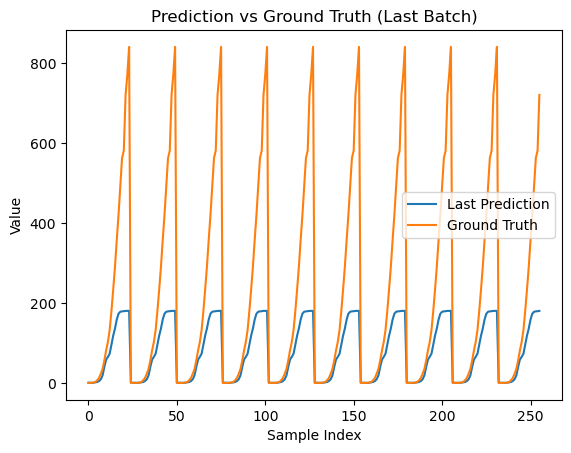

In [ ]:
# Assuming 'log' contains the logged predictions and ground truths
last_output, last_ground_truth = log[80]

# Convert the predictions and ground truth to NumPy arrays
# Flatten them if needed (to make plotting easier)
last_output_flat = last_output.cpu().numpy().flatten()  # Flatten the prediction tensor
last_ground_truth_flat = last_ground_truth.cpu().numpy().flatten()  # Flatten the ground truth tensor

# Plot the last prediction against the ground truth
plt.plot(last_output_flat, label="Last Prediction")
plt.plot(last_ground_truth_flat, label="Ground Truth")
plt.legend()
plt.title("Prediction vs Ground Truth (Last Batch)")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.show()


In [ ]:
# # torch.save(model, 'LSTM_model.pth')
# SAVE_PATH = 'LSTM_model_s3v1_nn6_8_1.pt'
# torch.save(model.state_dict(), SAVE_PATH)

In [ ]:
# #Load the Saved Model
# loaded_model = LSTMNet(6,8,1)
# loaded_model.load_state_dict(torch.load(SAVE_PATH))

<All keys matched successfully>

In [ ]:
# loaded_model.eval()

LSTMNet(
  (lstm): LSTM(6, 8, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)